In [2]:
import pandas as pd
from pandas import DataFrame,Series
import numpy as np
import matplotlib.pyplot as plt
import sklearn

ModuleNotFoundError: No module named 'scipy'

In [ ]:
import os
import tarfile
from urllib import request
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path): # 检查当前文件夹是否存在，如果不存在，创建一个文件夹
           os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz") # 连接两个地址，电脑文件地址
    request.urlretrieve(housing_url, tgz_path)     # 打开第一个链接下载到第二个电脑位置
    housing_tgz = tarfile.open(tgz_path)           # 打开文件
    housing_tgz.extractall(path=housing_path)     #  解压文件
    housing_tgz.close()              
    return pd.read_csv(os.path.join(housing_path,'housing.csv'))

In [89]:
# 导入数据
dataset=pd.read_csv('datasets/housing/housing.csv')
# 建立备份
datasetcopy=dataset.copy()
# 创建类别
datasetcopy['category']=np.ceil(datasetcopy.median_income/1.5)
datasetcopy.category.where(datasetcopy.category<5.0,5.0,inplace=True)
# 分层抽样
from sklearn.model_selection import StratifiedShuffleSplit
strat_split=StratifiedShuffleSplit(n_splits=1,random_state=10,test_size=0.2)
for trainix,testix in strat_split.split(datasetcopy,datasetcopy['category']):
      trainset=datasetcopy.iloc[trainix]
      testset=datasetcopy.iloc[testix]
# 验证下抽样效果
print(datasetcopy.category.value_counts(normalize=True))
print(trainset.category.value_counts(normalize=True))
print(testset.category.value_counts(normalize=True))

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: category, dtype: float64
3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: category, dtype: float64
3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: category, dtype: float64


In [92]:
# 在数据处理前，先检查下数据
trainset.notnull().sum() # 看看有误缺失值，可以看到total_bed_rooms存在缺失

longitude             16512
latitude              16512
housing_median_age    16512
total_rooms           16512
total_bedrooms        16351
population            16512
households            16512
median_income         16512
median_house_value    16512
ocean_proximity       16512
category              16512
dtype: int64

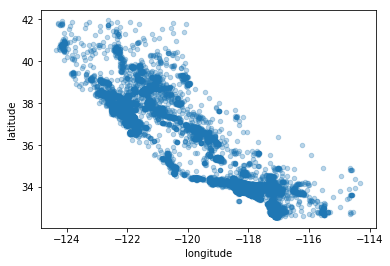

In [116]:
# 画图看看
trainset.plot(kind='scatter',x='longitude',y='latitude',alpha=0.3)
plt.show()
plt.close() # 颜色深的代表边上的类别比较多

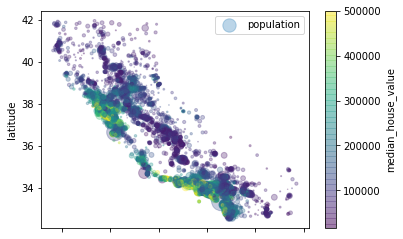

In [122]:
trainset.plot(kind='scatter',x='longitude',y='latitude',alpha=0.3,s=trainset.population/100,
              label='population',c='median_house_value',cmap=plt.get_cmap(),colorbar=True)
plt.show()
plt.close()

In [101]:
# 看看相关性
trainset.corr()['median_house_value'].sort_values(ascending=False) # 可以看见相关性

median_house_value    1.000000
median_income         0.688143
category              0.642582
total_rooms           0.133556
housing_median_age    0.105207
households            0.064821
total_bedrooms        0.047816
population           -0.025445
longitude            -0.047029
latitude             -0.142767
Name: median_house_value, dtype: float64

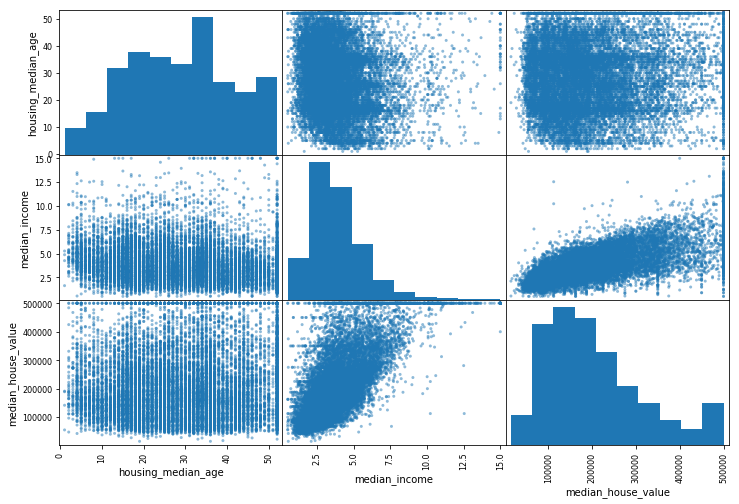

In [104]:
# 画下相关性的图
from pandas.plotting import scatter_matrix
attr=['housing_median_age','median_income','median_house_value']
scatter_matrix(trainset[attr],figsize=(12,8))
plt.show()
plt.close()

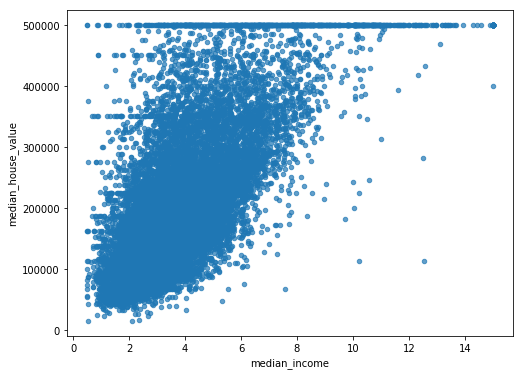

In [112]:
# 可以看见房价与收入关联性比较强
trainset.plot(kind='scatter',x='median_income',y='median_house_value',figsize=(8,6),alpha=0.7)
plt.show()
plt.close()

In [74]:
# 进行一些数据处理
# 1.对于total_rooms,bed_rooms,populations并非是我们想要的数据，可以考虑将去转化为rooms_per_household..
# 2.对于ocean_proximity这个字符型变量，考虑将其转化为数字变量
# 3.对于某些缺失值，想办法进行填补
# 4.scale
# 5.连接两个表
# 这个考虑使用pipeling
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.pipeline import  Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator,TransformerMixin
# 变量的提取--自定义类
class DataFrameSelector(BaseEstimator,TransformerMixin):
    def __init__(self,selectfeature):
        self.selectfeature=selectfeature
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        return X[self.selectfeature]
# 处理数据类--这个不可以复用
class VariableCombine(BaseEstimator,TransformerMixin):
    def __init__(self,baseix,totalroomsindex,bedroomsindex,populationindex):
        self.baseix=baseix
        self.totalroomsindex=totalroomsindex
        self.bedroomsindex=bedroomsindex
        self.populationindex=populationindex
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        rooms_per_household=X[:,self.totalroomsindex]/X[:,self.baseix]
        bedrooms_per_household=X[:,self.bedroomsindex]/X[:,self.baseix]
        population_per_household=X[:,self.populationindex]/X[:,self.baseix]
        return np.c_[X,rooms_per_household,bedrooms_per_household,population_per_household]
# 用于处理LabelBinarizer 不能在PIPELINE中使用
class friendlyLabelBinarizer(LabelBinarizer):
    def fit_transform(self,X,y=None):
        return super(friendlyLabelBinarizer,self).fit_transform(X)  # 因为父类只能接受一个参数，所以必须这样进行一个转化
# 使用pipeline连接
selectorcolumns=['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income']
fristpipe=Pipeline([
    ('selector1',DataFrameSelector(selectorcolumns)),
    ('imputer',Imputer(strategy='median')),
    ('variablecombine',VariableCombine(6,3,4,5)),
    ('stdchange',StandardScaler())
]
)
secondpipe=Pipeline([
    ('selector2',DataFrameSelector('ocean_proximity')),
    ('changeonezero',friendlyLabelBinarizer())
])  
combinepipe=FeatureUnion(transformer_list=[('frist',fristpipe),('second',secondpipe)])
anwtrain=combinepipe.fit_transform(trainset)
anwtest=combinepipe.fit_transform(testset)

In [75]:
# 可以转换成dataframe看看
onezero=np.unique(trainset.ocean_proximity)
per=np.array(['rooms_per_household','bedrooms_per_household','population_per_household'])
columnsseclct=np.array(selectorcolumns)
trainsetexlabel=DataFrame(anwtrain,columns=np.r_[columnsseclct,per,onezero])
testsetexlabel=DataFrame(anwtest,columns=np.r_[columnsseclct,per,onezero])
# 提取labels
trainsetlabels=trainset.median_house_value
testsetlabels=testset.median_house_value

In [76]:
# 模型拟合--线性模型
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
linearregression=LinearRegression()
linearregression.fit(trainsetexlabel,trainsetlabels)
prediction=linearregression.predict(trainsetexlabel)
np.sqrt(mean_squared_error(trainsetlabels,prediction))# 误差很小，过拟合，仅仅用自己来检查自己的话
prediction=linearregression.predict(testsetexlabel)
np.sqrt(mean_squared_error(testsetlabels,prediction))

68438.229849589407

In [77]:
from sklearn.tree import DecisionTreeRegressor
decisiontreeregression=DecisionTreeRegressor()
decisiontreeregression.fit(trainsetexlabel,trainsetlabels)
prediction=decisiontreeregression.predict(trainsetexlabel)
np.sqrt(mean_squared_error(trainsetlabels,prediction))  # 误差为0，严重过拟合

0.0

In [79]:
# 所以为了更好的避免训练集过拟合--overfitting---交叉严重
from sklearn.model_selection import cross_val_score
linercrossva=cross_val_score(cv=10,estimator=linearregression,X=trainsetexlabel,y=trainsetlabels,scoring='neg_mean_squared_error')
np.sqrt(-linercrossva)

array([ 69177.31552251,  73079.18568092,  69599.91445792,  69703.84156344,
        66088.79124478,  68595.83377994,  69125.23922421,  69922.23273528,
        67015.33624981,  68626.49479246])

In [80]:
from sklearn.model_selection import cross_val_score
decissiontreerossva=cross_val_score(cv=10,estimator=decisiontreeregression,X=trainsetexlabel,y=trainsetlabels,scoring='neg_mean_squared_error')
np.sqrt(-decissiontreerossva)

array([ 67991.28858108,  71000.76112234,  70895.4897843 ,  68478.04129049,
        70878.01566996,  70997.0175326 ,  73472.4698293 ,  68467.89066867,
        68657.1179731 ,  70729.10097644])

In [82]:
from sklearn.ensemble import RandomForestRegressor# 随机森林
rfmodel=RandomForestRegressor()
rfmodel.fit(trainsetexlabel,trainsetlabels)
rfscore=cross_val_score(cv=10,estimator=rfmodel,X=trainsetexlabel,y=trainsetlabels,scoring='neg_mean_squared_error')

In [84]:
np.sqrt(-rfscore) # 还是具有极大的误差

array([ 52205.40678939,  51577.96058176,  54939.78101907,  54546.70691456,
        50536.61136274,  54113.87376872,  54402.72571909,  53232.44705977,
        51746.75445189,  51540.79628708])

In [88]:
# 上面就是三种模型拟合的方法
linearregression.coef_ # 查看系数
predictions=linearregression.predict(testsetexlabel)
np.sqrt(mean_squared_error(predictions,testsetlabels)) # 反应在测试集上面的结果~-~

68438.229849589407

In [ ]:
# 超参数的选择方法---1.网格搜索，2.随机搜索，3.--这些等看了随机森林再说~~
# 网格搜索更好的参数
from sklearn.model_selection import GridSearchCV
param_grid = [
{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
scoring='neg_mean_squared_error')
grid_search.fit(final_train, train_labels)